# IR generation using IIR Linkwitz-Riley Crossover Filter Tree

A Linkwitz-Riley crossover filter is a pair of lowpass and highpass filters with -6dB magnitudes at the cutoff frequency $f_c$, giving a flat response in the transition region. It is generally designed with two cascaded 2nd order Butterworth filters, giving a -40dB/decade roll-off in the stop bands. In our case, we need multiple of these crossover filters frequencies to have individual control over each band based on the energy of the incident rays, which would look like a filter tree. 

A brief introduction to the design of LR crossover filters in the context of multi-band processing can be found [here](https://www.modernmetalproduction.com/linkwitz-riley-crossovers-digital-multiband-processing/). However, in our context we do not use the crossover filters to analyze an input signal. We rather synthesize a complete room impulse response by exciting the bands with an train of weighted impulses. Also, the filter tree used in our case is balanced as shown below.

<img src="https://gitlab.com/sat-metalab/vaRays/uploads/2700a97c36e28b4cc8e7370b41a9883f/LRFilterTree.png" alt="Drawing" width="900"/>

In the above figure, $f_{i}$ are the edge frequencies and $A_{i}$ are the 2nd order all-pass filters at respective edge frequencies, where $i\in{[0, 6]}$.

Every LR crossover filter introduces a 180$^o$ phase shift at the crossover frequency, which is not seen by the other LR filters in the tree. Hence, it is important to offset the phase of all filters using 2nd order all-pass filters at every other crossover frequency. Since all filters in the filter tree are LTI (linear time-invariant) systems, in our implementation, we use two simple tricks to reduce the number of computations:
- The poles of every filter pair are the same. Hence, we move the poles of the filters in every stage to the immediate next stage, where it becomes a common denominator,
- Since the same all-pass filters are applied to multiple LR filter pairs, we apply them in groups.

This method of generating impulse responses has the following advantages:
- The resulting filtered impulses are causal unlike the ones in the delayed-FIR kernel approach.
- The computational cost is proportional to the length of the IR and not the number of paths.
- At a relatively low cost, you can have impulses arriving between two samples by using [interpolating techniques](https://ccrma.stanford.edu/~jos/pasp/Delay_Line_Interpolation.html).

The python script below generates second order section coefficients for the LR filter tree described in this document for octave band frequencies between 125 Hz and 16000 Hz.

### Other useful references
- [Discussion thread](https://forum.juce.com/t/perfect-crossover-filters/36125) on using the all-pass filters to get flat band response.
- Implementation of the LR crossover filters in a [multiband dynamic range compressor](https://git.iem.at/audioplugins/IEMPluginSuite/tree/master/MultiBandCompressor).

In [4]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy.matlib
import json

In [5]:
freqs = np.array([125, 250, 500, 1000, 2000, 4000, 8000, 16000])    # Center frequencies of the frequency bands
fs = 48000

# Get poles, zeros and filter constants for 2nd order Butterworth lowpass and highpass filters for the above bands
zLPF = []
pLPF = []
kLPF = []
zHPF = []
pHPF = []
kHPF = []

bandEdges = np.sqrt(freqs[:-1]*freqs[1:])   # Crossover frequencies

for f in bandEdges:
    z, p, k = sig.iirfilter(2, f*2/fs, btype="lowpass", output='zpk')
    zLPF.append(z)
    pLPF.append(p)
    kLPF.append(k)
    z, p, k = sig.iirfilter(2, f*2/fs, btype="highpass", output='zpk')
    zHPF.append(z)
    pHPF.append(p)
    kHPF.append(k)
zLPF = np.array(zLPF)
pLPF = np.array(pLPF)
kLPF = np.array(kLPF)
zHPF = np.array(zHPF)
pHPF = np.array(pHPF)
kHPF = np.array(kHPF)

In [6]:
# Compute the SOS coefficients for all filters in each filter stage
SOS = []
numStages = np.ceil(np.log2(len(freqs))).astype(int)

# Filter stage 1
sos0 = []
for i in list(range(2**0 - 1, 2**(numStages)-1, 2**(1))):
    sos = sig.zpk2sos(np.append(zLPF[i, :], zLPF[i, :]), [], kLPF[i]*kLPF[i])
    sos0.append(sos)
    sos = sig.zpk2sos(np.append(zHPF[i, :], zHPF[i, :]), [], kHPF[i]*kHPF[i])
    sos0.append(sos)
SOS.append(sos0)

# Filter stage 2
sos1 = []
for i in list(range(2**1 - 1, 2**(numStages)-1, 2**(2))):
    z_LPF = np.append(np.matlib.repmat(zLPF[i, :], 1, 2), 1 / np.conjugate(pLPF[i + 1,:]))
    p_LPF = np.append(np.matlib.repmat(pLPF[i - 1, :], 1, 2), pLPF[i + 1,:])
    k_LPF = kLPF[i]**2 * np.abs(pLPF[i + 1, 0]**2)
    z_HPF = np.append(np.matlib.repmat(zHPF[i, :], 1, 2), 1 / np.conjugate(pLPF[i - 1,:]))
    p_HPF = np.append(np.matlib.repmat(pLPF[i + 1, :], 1, 2), pLPF[i - 1,:])
    k_HPF = kHPF[i]**2 * np.abs(pLPF[i - 1, 0]**2)

    sos = sig.zpk2sos(z_LPF, p_LPF, k_LPF)
    sos1.append(sos)
    sos = sig.zpk2sos(z_HPF, p_HPF, k_HPF)
    sos1.append(sos)
SOS.append(sos1)

# Filter stage 3
sos2 = []

z_LPF = np.append(np.matlib.repmat(zLPF[3, :], 1, 2), np.reshape(1 / np.conjugate(pLPF[4:, :]), -1, 'C'))
p_LPF = np.append(np.matlib.repmat(pLPF[1, :], 1, 2), np.reshape(pLPF[4:,:], -1, 'C'))
k_LPF = kLPF[3]**2 * np.prod(np.abs(pLPF[4:, 0])**2)
z_HPF = np.append(np.matlib.repmat(zHPF[3, :], 1, 2), np.reshape(1 / np.conjugate(pLPF[:3, :]), -1, 'C'))
p_HPF = np.append(np.matlib.repmat(pLPF[5, :], 1, 2), np.reshape(pLPF[:3,:], -1, 'C'))
k_HPF = kHPF[3]**2 * np.prod(np.abs(pLPF[:3, 0])**2)

sos = sig.zpk2sos(z_LPF, p_LPF, k_LPF)
sos2.append(sos)
sos = sig.zpk2sos(z_HPF, p_HPF, k_HPF)
sos2.append(sos)
SOS.append(sos2)

# Final stage
sos = sig.zpk2sos([], np.squeeze(np.matlib.repmat(pLPF[3, :], 1, 2)), 1)
SOS.append([sos])

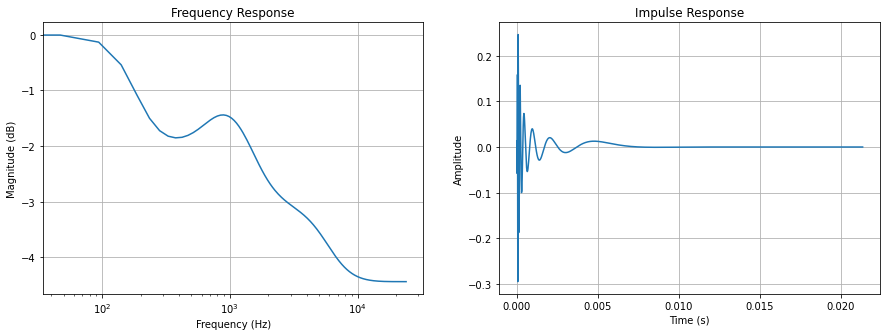

In [7]:
# Test with a set of coefficients by filtering in the time domain
gains = [1, 0.8, 0.8, 0.9, 0.7, 0.7, 0.6, 0.6]
N = 1024

imp = np.zeros((N, ))
imp[0] = 1

y0 = np.zeros((8, N))
for i in range(8):
    y0[i, :] = sig.sosfilt(SOS[0][i], gains[i]*imp)

y1 = np.zeros((4, N))
y1[0,:] = sig.sosfilt(SOS[1][0], y0[0, :] + y0[1, :])
y1[1,:] = sig.sosfilt(SOS[1][1], y0[2, :] + y0[3, :])
y1[2,:] = sig.sosfilt(SOS[1][2], y0[4, :] + y0[5, :])
y1[3,:] = sig.sosfilt(SOS[1][3], y0[6, :] + y0[7, :])

y2 = np.zeros((2, N))
y2[0, :] = sig.sosfilt(SOS[2][0], y1[0, :] + y1[1, :])
y2[1, :] = sig.sosfilt(SOS[2][1], y1[2, :] + y1[3, :])

y = np.zeros((1, N))
y[0, :] = sig.sosfilt(SOS[3][0], y2[0, :] + y2[1, :])

plt.figure(figsize=(15,5))
plt.subplot(121)
Y = np.fft.fft(y[0,:], n=N)
plt.plot(np.linspace(0, fs/2, N//2), 20*np.log10(np.abs(Y[:N//2])))
plt.title("Frequency Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xscale("log")
plt.grid()

plt.subplot(122)
plt.plot(np.linspace(0, N/fs, N), y[0,:])
plt.title("Impulse Response")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()

In [30]:
# Save coefficients to json file
from itertools import chain

data = {}
data['FilterBands'] = freqs.tolist()
data['BandGains'] = gains
data['WavFilename'] = "check_varaysEncoder.wav"

wavwrite(f"../../../../tests/{data['WavFilename']}", fs, y[0, :].astype(np.float32))
with open("../../../../tests/check_varaysEncoder.json", "w") as outfile:
    json.dump(data, outfile, indent=4)